<a href="https://colab.research.google.com/github/nagayahita/brand-sentiment-analyzer/blob/main/brand_sentiment_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("Downloading required NLTK resources...")
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
df = pd.read_csv('Twitter_Data.csv')

print("=== Dataset Overview ===")
print(f"Total samples: {len(df)}")
print("\nDataset Info:")
print(df.info())

print("\n=== Sample Data ===")
print(df.head())

=== Dataset Overview ===
Total samples: 162980

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB
None

=== Sample Data ===
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0


=== Sentiment Distribution ===

Count per category:
category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64

Percentage per category:
category
 1.0    44.3
 0.0    33.9
-1.0    21.8
Name: proportion, dtype: float64


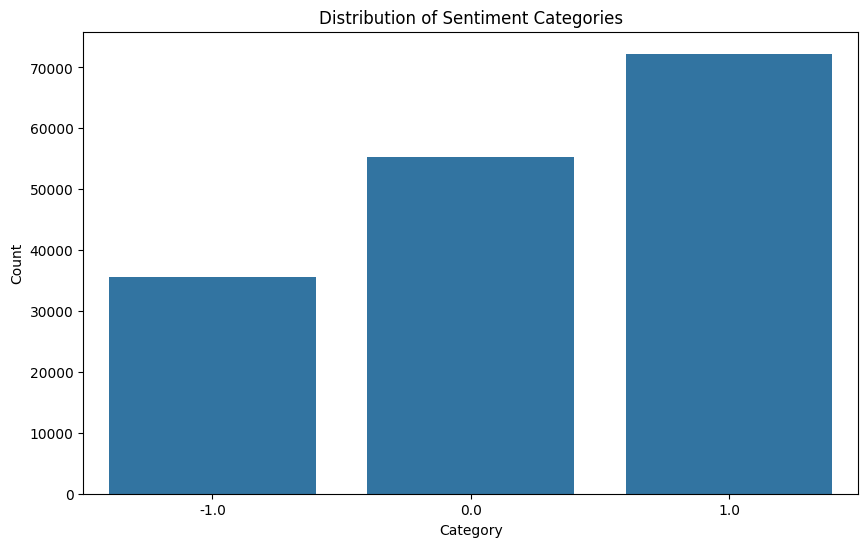

In [23]:
print("=== Sentiment Distribution ===")
sentiment_dist = df['category'].value_counts()
print("\nCount per category:")
print(sentiment_dist)
print("\nPercentage per category:")
print(df['category'].value_counts(normalize=True).round(3) * 100)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

=== Text Length Statistics ===
count    162976.000000
mean        124.176492
std          67.923285
min           1.000000
25%          66.000000
50%         114.000000
75%         183.000000
max         274.000000
Name: text_length, dtype: float64


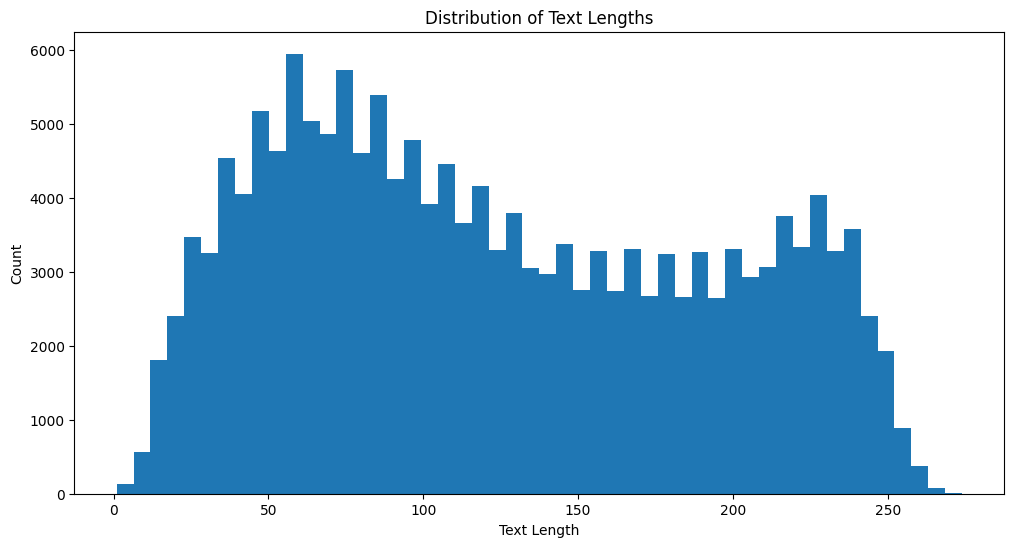


=== Sample Texts by Category ===

Category -1.0:
['coalition led modis hindu nationalist bharatiya janata party bjp widely expected retain power staggered election beginning april '
 'political parties crying foul over modi’ speech today mcc not violated per sources insiders say ’ national security issue and need not take permission for such announcements let’ see how the debate right wrong unfolds'
 'one will jail because rahul gandhi have not proof for corruption against modi but rahul sonia may police station for daily report for not leave india without inform ']

Category 0.0:
['that why read modi mind you need eat almonds not drink raga urine'
 'historic space breakthrough india becomes elite space power with ‘mission shakti’ announces modi via '
 'but modi his bakths just knew how injure others']

Category 1.0:
['exactly one day majoritarian sanghoos will make all those who speak truth muslims and all muslims pakistani and sanghoos still want modi export beef pakistan and rss bj

In [24]:
df['text_length'] = df['clean_text'].str.len()

print("=== Text Length Statistics ===")
print(df['text_length'].describe())

plt.figure(figsize=(12, 6))
plt.hist(df['text_length'], bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

print("\n=== Sample Texts by Category ===")

valid_categories = df['category'].dropna().unique()

for category in valid_categories:
    print(f"\nCategory {category}:")
    category_samples = df[df['category'] == category]['clean_text'].sample(n=3, replace=True)
    print(category_samples.values)

print("\n=== Category Information ===")
print("Category counts (including NaN):")
print(df['category'].value_counts(dropna=False))

In [40]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stopwords = set(stopwords.words('english'))

    def preprocess_text(self, text):

        try:

            text = str(text)


            text = text.lower()

            words = text.split()

            cleaned_words = [
                self.lemmatizer.lemmatize(word)
                for word in words
                if word not in self.stopwords
            ]

            return ' '.join(cleaned_words)
        except Exception as e:
            print(f"Error processing text: {str(e)}")
            return text

    def preprocess_dataset(self, texts):

        return [self.preprocess_text(text) for text in texts]


preprocessor = TextPreprocessor()

In [31]:
print("Preprocessing texts...")
try:

    batch_size = 1000
    processed_texts = []

    for i in range(0, len(df), batch_size):
        batch = df['clean_text'].iloc[i:i+batch_size]
        processed_batch = preprocessor.preprocess_dataset(batch)
        processed_texts.extend(processed_batch)

    df['processed_text'] = processed_texts

    print("\n=== Sample Processed Texts ===")
    print("Original vs Processed:")
    for i in range(3):
        print(f"\nOriginal: {df['clean_text'].iloc[i]}")
        print(f"Processed: {df['processed_text'].iloc[i]}")

except Exception as e:
    print(f"Error during preprocessing: {str(e)}")


Preprocessing texts...

=== Sample Processed Texts ===
Original vs Processed:

Original: when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
Processed: modi promised “minimum government maximum governance” expected begin difficult job reforming state take year get justice state business exit psus temple

Original: talk all the nonsense and continue all the drama will vote for modi 
Processed: talk nonsense continue drama vote modi

Original: what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax
Processed: say vote modi welcome bjp told rahul main campaigner modi think modi relax


In [42]:
df_clean = df.dropna(subset=['category'])

print("=== TF-IDF Vectorization ===")
tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(df_clean['processed_text'])
y = df_clean['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

feature_names = tfidf.get_feature_names_out()
print("\nTop features (words):")
print(feature_names[:10])



=== TF-IDF Vectorization ===
Training set shape: (130378, 5000)
Testing set shape: (32595, 5000)

Top features (words):
['100' '1000' '10000' '111' '1145' '1200' '12000' '125' '12k' '130']


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time


    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'training_time': train_time,
        'predictions': y_pred
    }


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}


results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    results[name] = train_and_evaluate(
        model, X_train, X_test, y_train, y_test, name
    )
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Training time: {results[name]['training_time']:.2f} seconds")


Training Logistic Regression...
Accuracy: 0.8789
Training time: 13.98 seconds

Training Naive Bayes...
Accuracy: 0.7197
Training time: 0.09 seconds

Training Random Forest...
Accuracy: 0.8482
Training time: 438.25 seconds



Analysis for Logistic Regression:

=== Detailed Report for Logistic Regression ===
              precision    recall  f1-score   support

        -1.0       0.87      0.76      0.81      7230
         0.0       0.85      0.96      0.90     10961
         1.0       0.91      0.88      0.89     14404

    accuracy                           0.88     32595
   macro avg       0.88      0.87      0.87     32595
weighted avg       0.88      0.88      0.88     32595



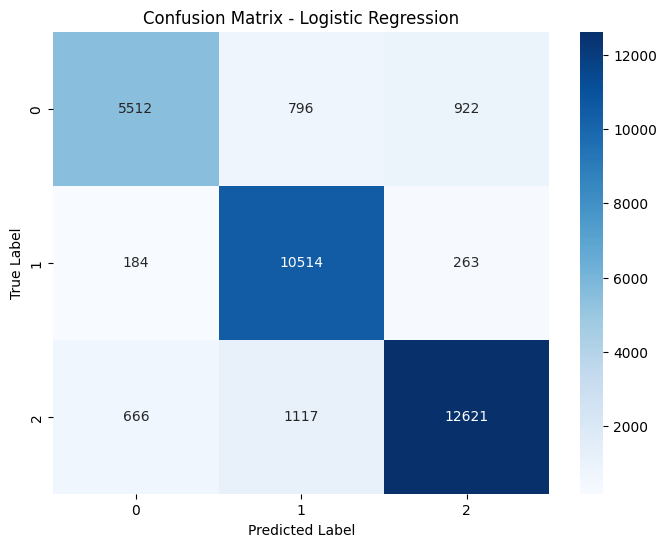


Analysis for Naive Bayes:

=== Detailed Report for Naive Bayes ===
              precision    recall  f1-score   support

        -1.0       0.87      0.43      0.57      7230
         0.0       0.82      0.65      0.73     10961
         1.0       0.65      0.92      0.76     14404

    accuracy                           0.72     32595
   macro avg       0.78      0.67      0.69     32595
weighted avg       0.76      0.72      0.71     32595



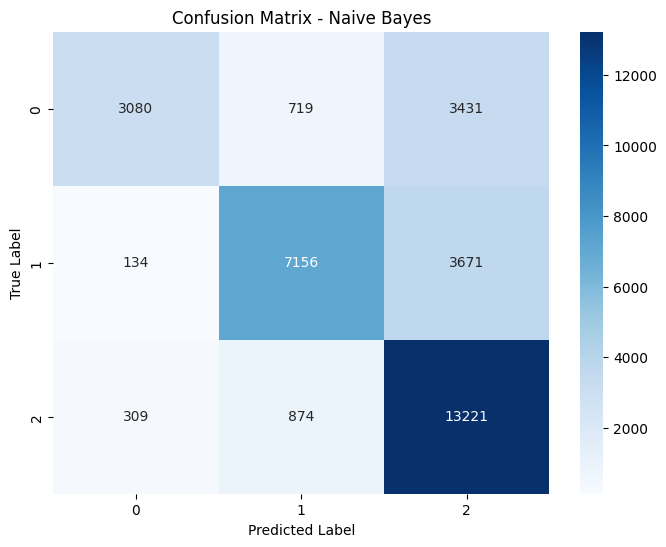


Analysis for Random Forest:

=== Detailed Report for Random Forest ===
              precision    recall  f1-score   support

        -1.0       0.85      0.68      0.75      7230
         0.0       0.83      0.94      0.88     10961
         1.0       0.87      0.86      0.86     14404

    accuracy                           0.85     32595
   macro avg       0.85      0.83      0.83     32595
weighted avg       0.85      0.85      0.85     32595



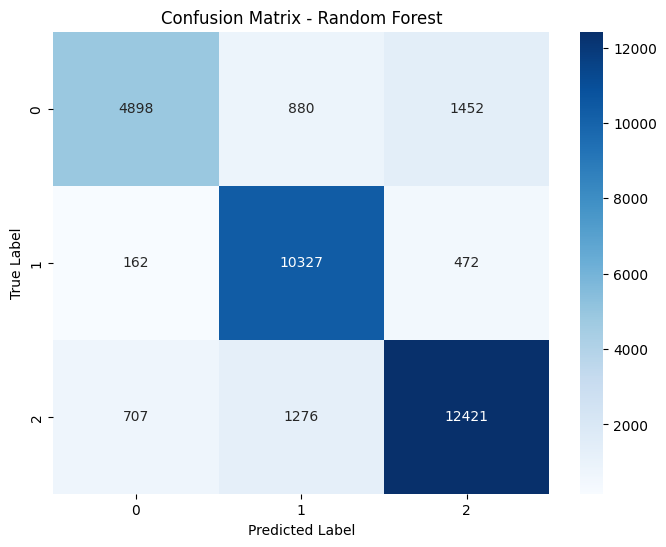

In [47]:
def plot_confusion_matrix(y_true, y_pred, model_name):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def print_detailed_report(y_true, y_pred, model_name):

    print(f"\n=== Detailed Report for {model_name} ===")
    print(classification_report(y_true, y_pred))


for name, result in results.items():
    print(f"\nAnalysis for {name}:")

    print_detailed_report(y_test, result['predictions'], name)

    plot_confusion_matrix(y_test, result['predictions'], name)

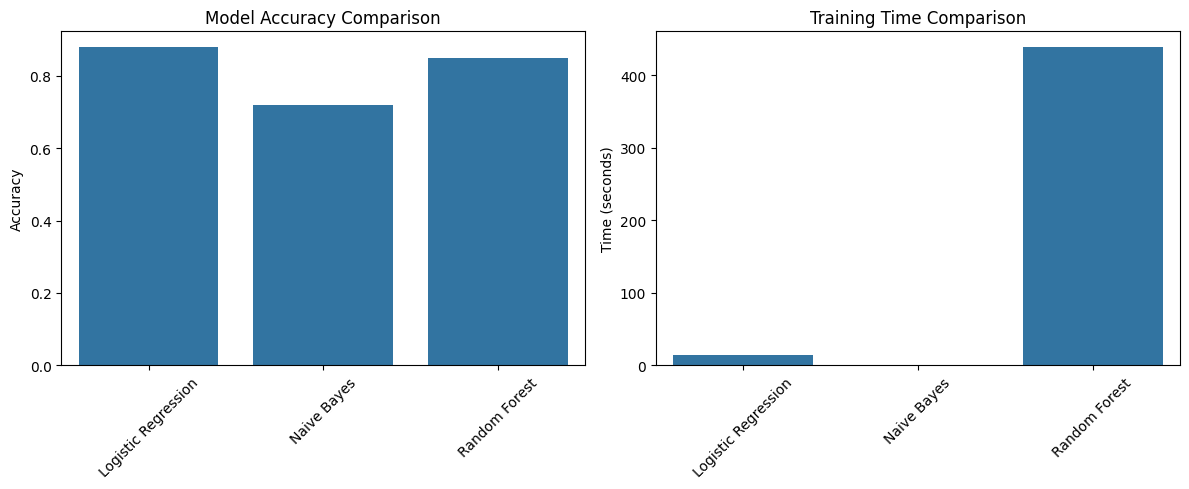

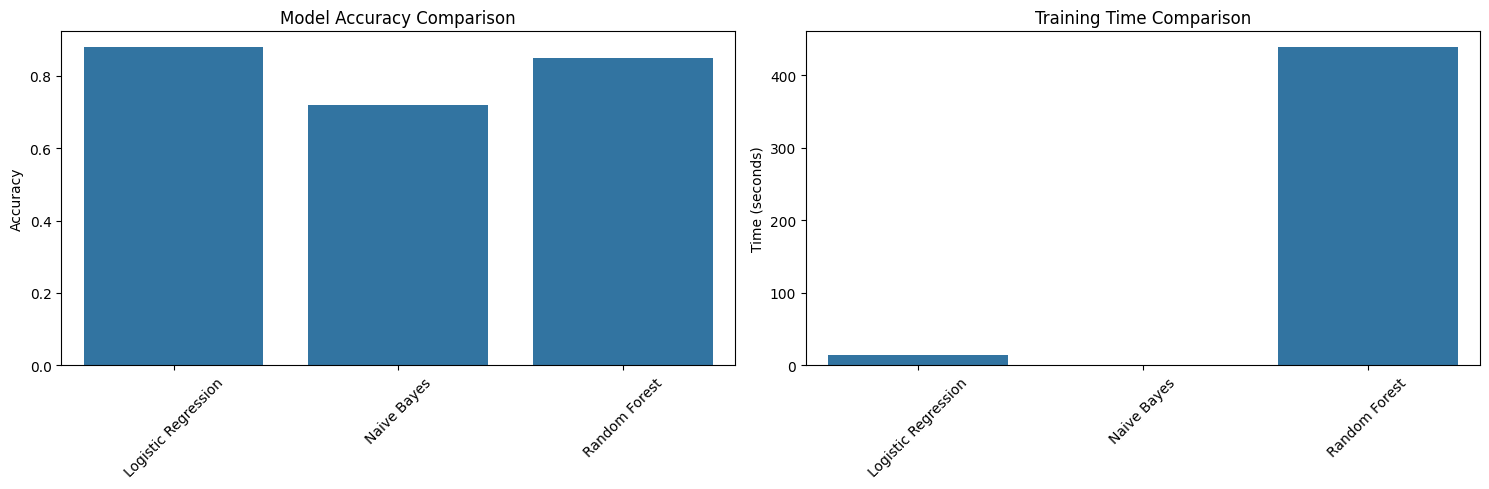

In [48]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
accuracies = [results[model]['accuracy'] for model in results]
sns.barplot(x=list(results.keys()), y=accuracies)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
times = [results[model]['training_time'] for model in results]
sns.barplot(x=list(results.keys()), y=times)
plt.title('Training Time Comparison')
plt.xticks(rotation=45)
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()
plot_model_comparison()

In [49]:
from IPython.display import display, HTML
import ipywidgets as widgets

def create_prediction_interface():



    text_input = widgets.Textarea(
        value='',
        placeholder='Masukkan teks untuk dianalisis...',
        description='Text:',
        disabled=False,
        layout={'width': '70%', 'height': '100px'}
    )


    model_select = widgets.Dropdown(
        options=list(results.keys()),
        description='Model:',
        style={'description_width': 'initial'}
    )

    def predict_sentiment(text, model_name):
        """Fungsi untuk melakukan prediksi"""
        try:

            processed = preprocessor.preprocess_text(text)


            vectorized = tfidf.transform([processed])


            prediction = models[model_name].predict(vectorized)[0]


            sentiment_map = {
                -1.0: "Negatif",
                0.0: "Netral",
                1.0: "Positif"
            }

            return sentiment_map.get(prediction, str(prediction))
        except Exception as e:
            return f"Error in prediction: {str(e)}"

    def on_analyze_click(b):
        """Handler untuk tombol analisis"""
        text = text_input.value
        model_name = model_select.value

        if text:

            sentiment = predict_sentiment(text, model_name)


            print("\n=== Sentiment Analysis Result ===")
            print(f"Text: {text}")
            print(f"Processed Text: {preprocessor.preprocess_text(text)}")
            print(f"Predicted Sentiment: {sentiment}")
        else:
            print("Please enter some text to analyze")


    analyze_button = widgets.Button(
        description="Analyze Sentiment",
        button_style='info'  # Warna biru
    )
    analyze_button.on_click(on_analyze_click)


    print("=== Interactive Sentiment Analysis ===")
    print("Enter text and choose a model to analyze sentiment")
    display(widgets.VBox([
        text_input,
        model_select,
        analyze_button
    ]))

create_prediction_interface()

=== Interactive Sentiment Analysis ===
Enter text and choose a model to analyze sentiment



=== Sentiment Analysis Result ===
Text: "I absolutely love this product! The customer service was amazing and delivery was super fast. Highly recommended!"
Processed Text: "i absolutely love product! customer service amazing delivery super fast. highly recommended!"
Predicted Sentiment: Positif
